# Matrix Factorization 
using [MoiveLens](https://grouplens.org/datasets/movielens/) latest dataset. 
Small: 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. Last updated 10/2016.

$$\hat{R} = P Q^T$$

where $R \in \{0,1,2,3,4,5\}^{N \times D}, P \in \{0,1,2,3,4,5\}^{N \times K}, Q \{0,1,2,3,4,5\}^{D \times K}$. N is the number of users, D is the number of items (movies), K is the number of latent features. Ratings range from 1 to 5. If a users doesn't rate a movie, annotate 0. 

Least square errors + regularization + bias

Learning algorithm : 
1. Alternative least squares (ALS)
2. Stochastic gradient descent (SGD)

Some useful tutorials/ papers:

[Koren'09](https://cseweb.ucsd.edu/classes/fa17/cse291-b/reading/Recommender-Systems.pdf)

[explicit-matrix-factorization-sgd-als](http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/)

[lazyprogrammer.me](https://lazyprogrammer.me/tutorial-on-collaborative-filtering-and-matrix-factorization-in-python/)

[Tutorial](https://getpocket.com/a/read/1908096725)



In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv',header=0, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies_df = pd.read_csv('./ml-latest-small/movies.csv',header=0, names= ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
R = R_df.values

In [6]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations, alg):
        """
        Perform matrix factorization to predict empty
        entries in a matrix, using ALS.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        - alg (str)     : learning algorithm （ALS, SGD）
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.alg = alg
        
    def train_test_split(self):
        """
        Split into training and test sets. 
        Remove 10 ratings for each user and assign them to the test set
        """
        
        self.test = np.zeros(self.R.shape)
        self.train = self.R.copy()
        for user in range(self.R.shape[0]):
            test_ratings = np.random.choice(self.R[user, :].nonzero()[0], 
                                            size=10, 
                                            replace=False)
            self.train[user, test_ratings] = 0.
            self.test[user, test_ratings] = R[user, test_ratings]

        # Test and training are truly disjoint
        assert(np.all((self.train * self.test) == 0)) 

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        self.train_test_split()
      
        # Create a list of training dict
        self.ratings_by_i = defaultdict(list)
        self.ratings_by_j = defaultdict(list)
        self.samples = []
        self.num_rating = 0
        for i in range(self.num_users):
            for j in range(self.num_items):
                if self.train[i][j] > 0:
                    self.num_rating += 1
                    self.ratings_by_i[i].append((j,R[i][j]))
                    self.ratings_by_j[j].append((i,R[i][j]))
                    self.samples.append((i, j, self.R[i, j]))

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        testing_process = []
        for i in range(self.iterations):
            if self.alg == 'ALS':
                self.als()
            elif self.alg == 'SGD':
                self.sgd()
            else:
                raise ValueError('Wrong alg input.')
            train_rmse, test_rmse = self.mse()
            training_process.append((i, train_rmse))
            testing_process.append((i, test_rmse))
            
            if (i+1) % 5 == 0:
                print("Iteration: %d ; training error = %.4f; testing error = %.4f" % (i+1, train_rmse, test_rmse))
        
        return training_process, testing_process
    
    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs_train, ys_train = self.train.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs_train, ys_train):
            error += pow(self.train[x, y] - predicted[x, y], 2)
        train_rmse = np.sqrt(error/len(xs_train))
        
        xs_test, ys_test = self.test.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs_test, ys_test):
            error += pow(self.test[x, y] - predicted[x, y], 2)
        test_rmse = np.sqrt(error/len(xs_test))
        
        
        return train_rmse, test_rmse 

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
      
    def als(self):
        
        # update b_u
        for i in range(self.num_users):
            if i in self.ratings_by_i:
                accum = 0
                for j, r in self.ratings_by_i[i]:
                    accum += (r - self.P[i,:].dot(self.Q[j, :]) - self.b_i[j] - self.b)
                self.b_u[i] = accum / (1 + self.beta) / len(self.ratings_by_i[i])
        #afterB = timeit.default_timer()
        #print('afterB:', afterB- start)

        # update P
        for i in range(self.num_users):
            if i in self.ratings_by_i:
                matrix = np.zeros((self.K, self.K)) + self.beta*np.eye(self.K)
                vector = np.zeros(self.K)
                for j, r in self.ratings_by_i[i]:
                    matrix += np.outer(self.Q[j,:], self.Q[j,:])
                    vector += (r - self.b_u[i] - self.b_i[j] - self.b)*self.Q[j, :]
                self.P[i,:] = np.linalg.solve(matrix, vector)
        afterU = timeit.default_timer()
        #print('afterU:', afterU- afterB)

        # update b_i
        for j in range(self.num_items):
            if j in self.ratings_by_j:
                accum = 0
                for i, r in self.ratings_by_j[j]:
                    accum += (r - self.P[i,:].dot(self.Q[j, :]) - self.b_u[i] - self.b)
                self.b_i[j] = accum / (1 + self.beta) / len(self.ratings_by_j[j])
        afterC = timeit.default_timer()
        #print('afterC:', afterC- afterU)

        # update Q
        for j in range(self.num_items):
            if j in self.ratings_by_j:
                matrix = np.zeros((self.K, self.K)) + self.beta*np.eye(self.K)
                vector = np.zeros(self.K)
                for i, r in self.ratings_by_j[j]:
                    matrix += np.outer(self.P[i,:], self.P[i,:])
                    vector += (r - self.b_u[i] - self.b_i[j] - self.b)*self.P[i,:]
                self.Q[j, :] = np.linalg.solve(matrix, vector)
        afterV = timeit.default_timer()
        #print('afterV:', afterV- afterC)

    def get_rating(self, i, j):
            """
            Get the predicted rating of user i and item j
            """
            prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
            return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [7]:
mf_als = MF(R, K=100, alpha=0.05, beta=0.01, iterations=50, alg = 'ALS')
training_process, testing_process = mf_als.train()

Iteration: 5 ; training error = 0.0189; testing error = 1.1707
Iteration: 10 ; training error = 0.0069; testing error = 1.0857
Iteration: 15 ; training error = 0.0042; testing error = 1.0601
Iteration: 20 ; training error = 0.0032; testing error = 1.0454
Iteration: 25 ; training error = 0.0026; testing error = 1.0381
Iteration: 30 ; training error = 0.0022; testing error = 1.0349
Iteration: 35 ; training error = 0.0019; testing error = 1.0329
Iteration: 40 ; training error = 0.0017; testing error = 1.0312
Iteration: 45 ; training error = 0.0015; testing error = 1.0300
Iteration: 50 ; training error = 0.0014; testing error = 1.0294


In [8]:
print("MF using ALS:")
print()
print("P x Q:")
print(mf_als.full_matrix())
#print(mf_als.P.dot(mf.Q.transpose))
print()
print("Global bias:")
print(mf_als.b)
print()
print("User bias:")
print(mf_als.b_u)
print()
print("Item bias:")
print(mf_als.b_i)

x_train_als = [x for x, y in training_process]
y_train_als = [y for x, y in training_process]

x_test_als = [x for x, y in testing_process]
y_test_als = [y for x, y in testing_process]

MF using ALS:

P x Q:
[[3.08416371 2.53128881 2.59657405 ... 4.04880742 2.58207959 3.6981718 ]
 [3.81414205 3.39466537 3.5130541  ... 4.37873191 3.08946207 4.14874964]
 [3.6236848  3.11912175 2.98244258 ... 4.47480428 3.14028069 4.23702771]
 ...
 [3.32538887 3.07021968 3.19266273 ... 4.35490878 3.00741609 4.10638791]
 [3.99766239 3.99827927 3.07441206 ... 4.59211253 3.26233606 4.35573377]
 [4.98768948 3.11375957 3.42422277 ... 4.81617598 3.41200233 4.49756139]]

Global bias:
3.543608255669773

User bias:
[-5.76401896e-01 -1.15561347e-01 -5.28740242e-02  4.83126763e-01
  1.98417868e-01 -2.48774943e-01 -8.14275886e-02  1.77584534e-01
  8.82678896e-02  3.32536296e-02  3.34141675e-01 -4.40721468e-01
  2.19093698e-01 -2.96561222e-01 -5.46718325e-01  3.68577446e-01
  1.49512854e-01 -1.99253175e-01 -1.26887844e-02 -2.07187454e-01
 -6.60910394e-03 -1.51199186e-01  6.52889818e-02  5.86785051e-02
 -3.40689643e-01 -6.48602630e-02  3.73082105e-02  4.53624690e-01
 -5.26270347e-01  1.42788979e-01  3

In [9]:
mf = MF(R, K=100, alpha=0.05, beta=0.01, iterations=50, alg = 'SGD')
training_process, testing_process = mf.train()

Iteration: 5 ; training error = 0.5797; testing error = 0.9213
Iteration: 10 ; training error = 0.2567; testing error = 0.9381
Iteration: 15 ; training error = 0.1873; testing error = 0.9484
Iteration: 20 ; training error = 0.1667; testing error = 0.9504
Iteration: 25 ; training error = 0.1568; testing error = 0.9499
Iteration: 30 ; training error = 0.1507; testing error = 0.9488
Iteration: 35 ; training error = 0.1463; testing error = 0.9476
Iteration: 40 ; training error = 0.1430; testing error = 0.9464
Iteration: 45 ; training error = 0.1404; testing error = 0.9454
Iteration: 50 ; training error = 0.1383; testing error = 0.9444


In [10]:
print()
print("P x Q:")
print(mf.full_matrix())
#print(mf.P.dot(mf.Q.transpose))
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

x_train_sgd = [x for x, y in training_process]
y_train_sgd = [y for x, y in training_process]

x_test_sgd = [x for x, y in testing_process]
y_test_sgd = [y for x, y in testing_process]


P x Q:
[[2.8365356  2.39658028 2.23350423 ... 3.20041974 2.25252118 2.93545605]
 [3.48174669 3.91320314 2.90886665 ... 4.19954248 3.12615218 3.88946058]
 [2.94346036 3.16245691 3.23371544 ... 4.19737909 3.14081632 3.76471813]
 ...
 [4.20477779 3.1238204  1.94537758 ... 4.14335029 3.04332598 3.73210925]
 [4.00404981 4.31514677 4.01216077 ... 4.225688   3.46563613 4.26419464]
 [4.3065479  3.02357899 2.96914938 ... 4.04752043 3.31584619 3.77256651]]

Global bias:
3.543608255669773

User bias:
[-9.70596396e-01 -4.45122623e-02 -5.88316077e-02  6.75966443e-01
  1.85442429e-01 -3.54324769e-01 -2.14104111e-01  2.01091225e-02
 -1.14285949e-01  1.57254756e-01  2.59681045e-01 -6.34099643e-01
 -1.23395415e-01 -2.74051063e-01 -1.07850054e+00  3.72407588e-01
 -3.30237576e-02 -3.62622474e-03 -8.34839631e-02 -3.53367325e-01
 -1.28827114e-01 -2.87902222e-01 -1.72380853e-01 -9.80030771e-02
 -2.07769324e-01 -3.75154139e-01 -2.54167468e-02  2.41721929e-01
 -3.28554535e-01  2.25718798e-01  2.70593983e-01 

Text(0.5,1,'MF training RSME')

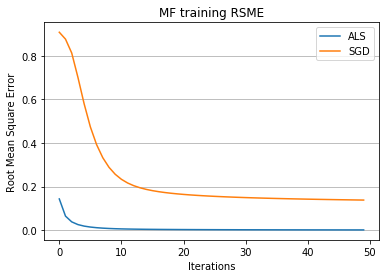

In [11]:
plt.figure(figsize=((6,4)))

plt.plot(x_train_als, y_train_als, label = "ALS")
plt.plot(x_train_sgd, y_train_sgd, label = "SGD")

plt.grid(axis="y")
plt.legend()

plt.xlabel("Iterations")
plt.ylabel("Root Mean Square Error")
plt.title("MF training RSME")

Text(0.5,1,'MF testing RSME')

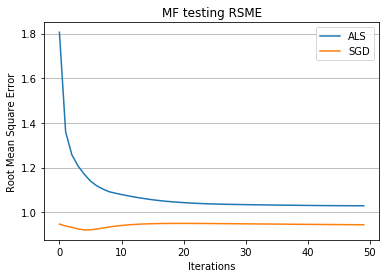

In [12]:
plt.figure(figsize=((6,4)))

plt.plot(x_test_als, y_test_als, label = "ALS")
plt.plot(x_test_sgd, y_test_sgd, label = "SGD")

plt.grid(axis="y")
plt.legend()

plt.xlabel("Iterations")
plt.ylabel("Root Mean Square Error")
plt.title("MF testing RSME")